# **ML Loan Processor**

# Imports
##### 1. Import Libraries
##### 2. Import Data

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
import sklearn.metrics as metrics

### Import Data

In [2]:
# Read in cleaned data from previous notebook
df = pd.read_csv('https://santiagox86-underwriter-1.s3.amazonaws.com/cleaned_df.csv')


# Model Building

In [3]:
# Establish a baseline based on percentage of loans that are actually good
baseline = len(df[df['loan_status']==1])/len(df)
baseline

0.8722752368082475

In [4]:
# Create X and y
X = df.drop(columns=['loan_status'])
y = df['loan_status']

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=23, test_size=.2, stratify=y)

# Production Model Fitting and Insights

In [6]:
# Instantiate GBClassifier
gb = GradientBoostingClassifier(learning_rate=0.125, max_depth=2, n_estimators=100)

In [7]:
# Fit model
gb.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.125, max_depth=2)

In [8]:
# Cross Val Score
cvs = cross_val_score(gb, X_train, y_train, cv=5).mean()

In [9]:
# GB Feature Importance
feat_imp = {k:v for k,v in list(zip(df.columns,gb.feature_importances_)) if v !=0}

In [10]:
# Test Prediction Probabilities
pred_proba = gb.predict_proba(X_test)

In [11]:
# Test Predictions
preds = gb.predict(X_test)

# Analyzing Model
##### 1. Analyze classification metrics for original model
##### 2. Create Resulting dataframe of test data for further analysis of model
##### 3. Create Dataframe of middle of the road loans that may have to be analyzed further by human underwriter
##### 4. Create Dataframe of "solid decision" loans to analyze whether they can be safely determined by the model
##### 5. Adjust model to decrease Type 1 errors

### Analyze classification metrics for original model
Using Scikit-Learn.metrics, obtain confusion matrices, Accuracy scores, Recall score, Specificity score, Precision score, and F1 score and plot various graphs to visualize results

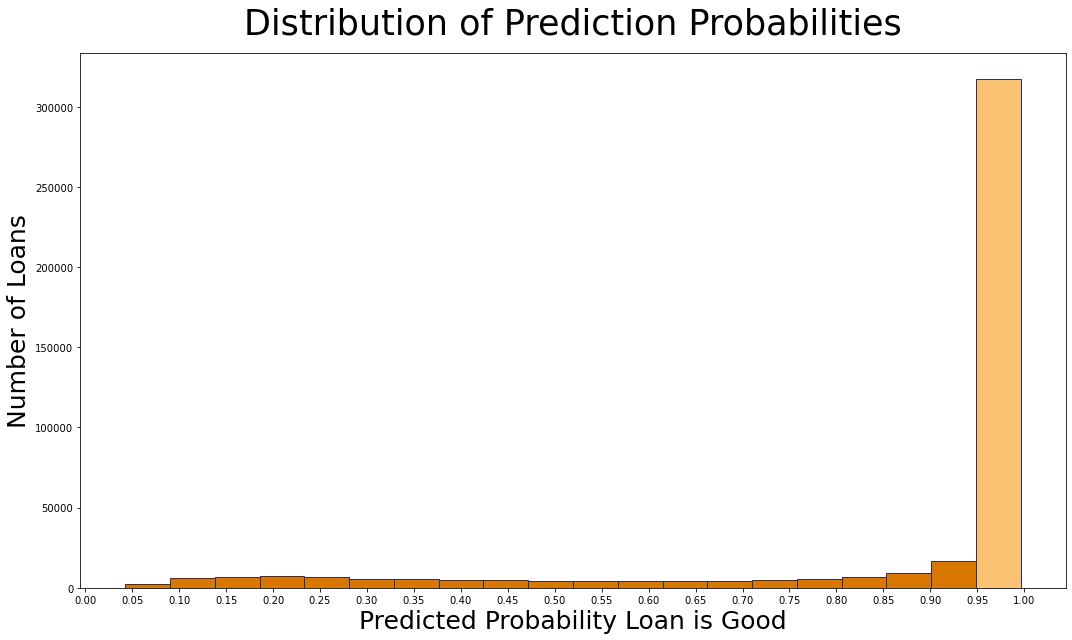

In [46]:
# Plot Histogram of prediction probabilities
fig, ax = plt.subplots(1,1, figsize=(15,9), facecolor='white')

ax.set_title('Distribution of Prediction Probabilities', loc='center', size=35, pad=20)
n,bins,patches = ax.hist(pred_proba[:,1],bins=20, color='#D87702', edgecolor='#262F72')
patches[19].set_fc('#FCC274')
ax.set_xlabel('Predicted Probability Loan is Good', size=25)
ax.set_ylabel('Number of Loans', size=25)
plt.xticks(list(np.arange(0,1.05,.05)))
plt.tight_layout();

In [19]:
# Calculate percentage of loans given a probability of >= .95
len([pp for pp in pred_proba[:,1] if pp >=.95])/len(pred_proba[:,1])

0.7326087961892429

In [20]:
# Confusion matrix dataframe
def conf_mat(actual,pred):
    return pd.DataFrame(metrics.confusion_matrix(actual,pred),
             columns=['pred bad', 'pred good'],
             index=['actual bad', 'actual good'])
conf_mat(y_test, preds)

,pred bad,pred good
actual bad,38445,16791
actual good,14012,363212


<ipython-input-21-44fa404e557a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, size=15)
<ipython-input-21-44fa404e557a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels, size=15)


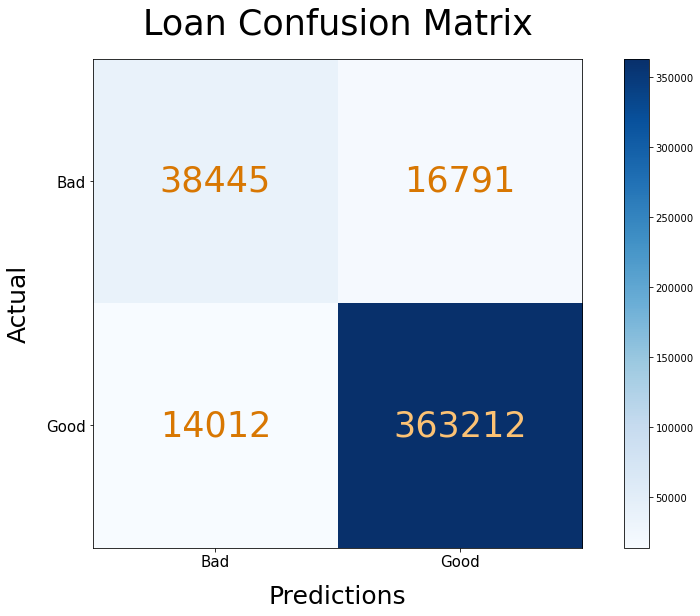

In [21]:
# Create function to plot confusion matrix
def plot_cm(actual, pred):
    matrix = metrics.confusion_matrix(actual,pred)
    fig = plt.figure(figsize=(15,9),facecolor='white')
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap='Blues')
    plt.title('Loan Confusion Matrix', size=35, pad=25)
    plt.xlabel('Predictions', size=25, labelpad=15)
    plt.ylabel('Actual', size=25, labelpad=15)
    labels = ['Bad','Good']
    ax.set_xticklabels(['']+labels, size=15)
    ax.set_yticklabels(['']+labels, size=15)
    ax.xaxis.set_ticks_position('bottom')
    mat = metrics.confusion_matrix(actual,pred)
    for k,v in enumerate(mat.T):
        for n,m in enumerate(v):
            if m < len(pred)/2:
                ax.text(k,n,m, color='#D87702', size=35, va='center', ha='center')
            else:
                ax.text(k,n,m, color='#FCC274', size=35, va='center', ha='center')
    fig.colorbar(cax);
    
plot_cm(y_test,preds)

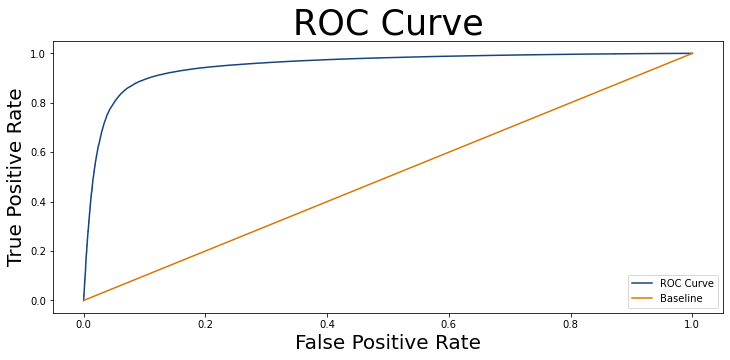

In [22]:
# Plot an ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, pred_proba[:,1])

plt.figure(figsize=(12,5), facecolor='white')

plt.plot(fpr, tpr, color='#16447D', label='ROC Curve')
plt.title('ROC Curve', size=35)
plt.plot([0,1],[0,1],color='#D87702', label='Baseline')
plt.xlabel('False Positive Rate', size=20)
plt.ylabel('True Positive Rate', size=20)
plt.legend()
plt.show()

In [23]:

def cl_metrics(actual,pred):
    # Create variables for classification metrics
    tn, fp, fn, tp = metrics.confusion_matrix(actual, pred).flatten()
    print('Total Loans: ', len(actual))
    print('Total Predicted Good: ', pred.sum())
    print('Total Predicted Bad: ', len(pred)-pred.sum())
    print('Accuracy Score: ', round(metrics.accuracy_score(actual, pred),3))
    print('Recall Score: ', round(metrics.recall_score(actual, pred),3))
    print('Specificity Score: ', round(tn/(tn+fp),3))
    print('Precision Score: ',round(metrics.precision_score(actual, pred),3))
    print('F1 Score: ', round(metrics.f1_score(actual, pred),3))
    
cl_metrics(y_test,preds)

Total Loans:  432460
Total Predicted GoodL  380003
Total Predicted Bad:  52457
Accuracy Score:  0.929
Recall Score:  0.963
Specificity Score:  0.696
Precision Score:  0.956
F1 Score:  0.959


### Create "Results" dataframe of test data
This will combine the original X_test and y_test data into a new dataframe as well as creating  'model_preds' and 'pred_probability' columns from GradientBoostingClassifier

In [24]:
# Create Results dataframe
Results = pd.DataFrame.copy(X_test)
# Add loan_status column
Results['loan_status'] = y_test.copy()
# Add model prediction column
Results['model_preds'] = preds.copy()
# Add prediction probability column
Results['pred_probability'] = pred_proba[:,1:].copy()

In [59]:
pred_1 = Results[Results['loan_status']==1][['pred_probability']]
pred_0 = Results[Results['loan_status']==0][['pred_probability']]
pred_un_50 = pred_0[pred_0['pred_probability']<.5]
pred_red = pred_0[pred_0['pred_probability']>=.5]


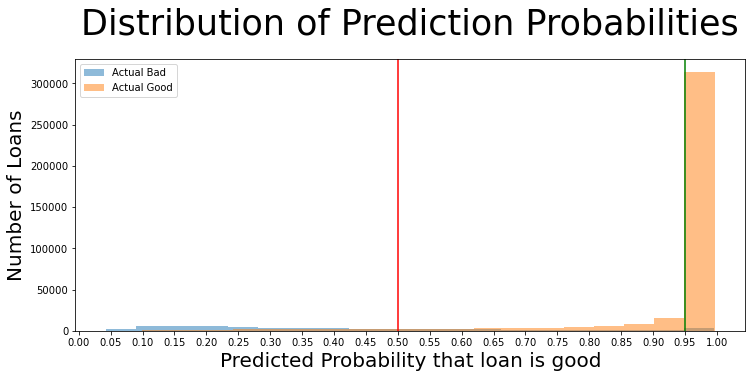

In [27]:
plt.figure(figsize = (12, 5), facecolor='white')

plt.title('Distribution of Prediction Probabilities', size=35, pad=25)
plt.hist(pred_0, bins=20, alpha=.5, label='Actual Bad')
plt.hist(pred_1, bins=20, alpha=.5, label='Actual Good')
plt.axvline(.5, color='red')
plt.axvline(.95, color='green')
plt.xlabel('Predicted Probability that loan is good', size=20)
plt.ylabel('Number of Loans', size=20)
plt.xticks(list(np.arange(0,1.05,.05)))
plt.legend();

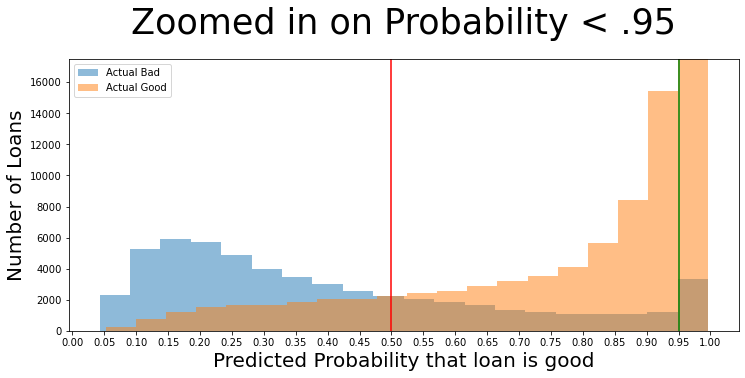

In [62]:
plt.figure(figsize = (12, 5), facecolor='white')

plt.ylim(0,17500)
plt.title('Zoomed in on Probability < .95', size=35, pad=25)
plt.hist(pred_0, bins=20, alpha=.5, label='Actual Bad')
plt.hist(pred_1, bins=20, alpha=.5, label='Actual Good')
plt.axvline(.5, color='red')
plt.axvline(.95, color='green')
plt.xlabel('Predicted Probability that loan is good', size=20)
plt.ylabel('Number of Loans', size=20)
plt.xticks(list(np.arange(0,1.05,.05)))
plt.legend();

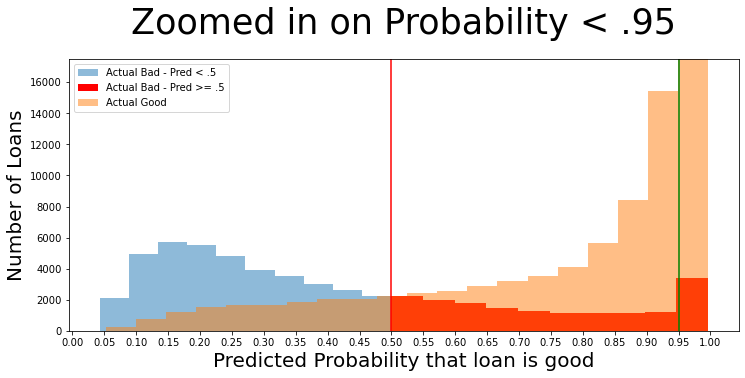

In [61]:
plt.figure(figsize = (12, 5), facecolor='white')

plt.ylim(0,17500)
plt.title('Zoomed in on Probability < .95', size=35, pad=25)
plt.hist(pred_un_50, bins=10, alpha=.5, label='Actual Bad - Pred < .5')
plt.hist(pred_red, bins=10, label='Actual Bad - Pred >= .5', color='red')
plt.hist(pred_1, bins=20, alpha=.5, label='Actual Good')
plt.axvline(.5, color='red')
plt.axvline(.95, color='green')
plt.xlabel('Predicted Probability that loan is good', size=20)
plt.ylabel('Number of Loans', size=20)
plt.xticks(list(np.arange(0,1.05,.05)))
plt.legend();

In [29]:
# Percentage of loans predicted good under main model
round(Results['model_preds'].sum()/len(Results),3)

0.879

In [30]:
# Display head of Results dataframe
Results.head()

,loan_amnt,term,sub_grade,annual_inc,pymnt_plan,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,...,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,loan_status,model_preds,pred_probability
1829896,10000.0,0,11,52000.0,0,27.42,0.0,680.0,684.0,0.0,...,0,0,0,0,0,0,0,0,0,0.352034
1019532,20000.0,0,9,47690.0,0,16.48,0.0,660.0,664.0,0.0,...,0,0,0,0,0,0,0,1,1,0.992051
2117713,25000.0,0,2,141000.0,0,7.40,0.0,755.0,759.0,0.0,...,0,0,0,0,0,0,0,0,0,0.120437
686812,9000.0,0,2,50500.0,0,10.92,0.0,740.0,744.0,1.0,...,0,0,0,0,0,0,0,1,1,0.992878
496303,20000.0,0,10,65000.0,0,18.81,0.0,700.0,704.0,0.0,...,0,0,0,0,0,0,0,1,1,0.994072


### Create Dataframe of mid-range probability loans
This dataframe is comprised of the loans that fall in a more questionable range of the 'pred_probability' column. These loans may be worth having a human underwriter examine further. Run classification metrics on this data to confirm that it is in fact questionable.


In [31]:
# Extract data for loans with mid-range probabilities
Questionable = Results[Results['pred_probability'].between(.25,.95)]

In [32]:
# Calculate percentage of X_test contained in "Questionable"
round(len(Questionable)/len(Results),3)

0.21

In [33]:
# Confusion matrix
conf_mat(Questionable['loan_status'],Questionable['model_preds'])

,pred bad,pred good
actual bad,17432,13505
actual good,10006,49674


<ipython-input-21-44fa404e557a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, size=15)
<ipython-input-21-44fa404e557a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels, size=15)


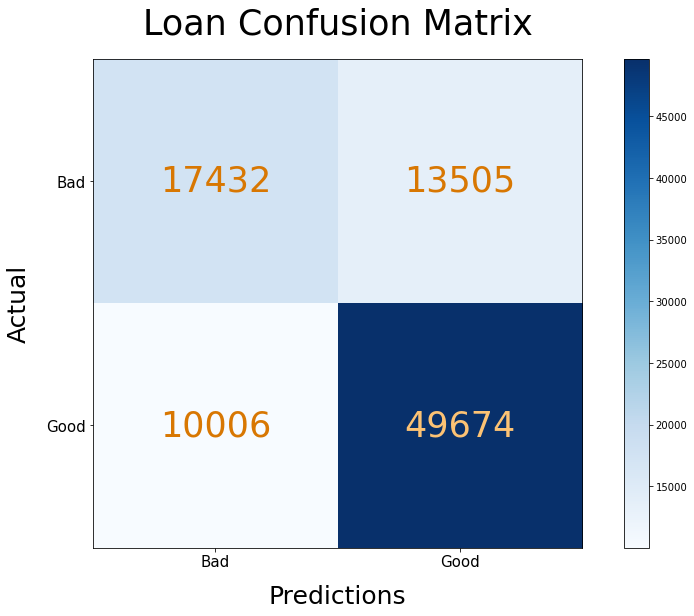

In [34]:
# Plot Confusion Matrix
plot_cm(Questionable['loan_status'],Questionable['model_preds'])

In [35]:
cl_metrics(Questionable['loan_status'],Questionable['model_preds'])

Total Loans:  90617
Total Predicted GoodL  63179
Total Predicted Bad:  27438
Accuracy Score:  0.741
Recall Score:  0.832
Specificity Score:  0.563
Precision Score:  0.786
F1 Score:  0.809


### Create Dataframe of "solid decision" loans
This dataframe should contain all loans that are in the Results dataframe but not in the "Questionable" dataframe. The model should be sufficient at predicting these loans to the point that it would be cost effective to forego further analysis by human underwriters and rely on the model to approve/deny loan

In [36]:
# Extract data for laons with more certain probabilities
Solid = Results[Results['pred_probability'].between(.25,.95)==False]

In [37]:
# Calculate percentage of X_test contained in "Solid"
round(len(Solid)/len(Results),3)

0.79

In [38]:
# Confusion matrix
conf_mat(Solid['loan_status'],Solid['model_preds'])

,pred bad,pred good
actual bad,21013,3286
actual good,4006,313538


<ipython-input-21-44fa404e557a>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, size=15)
<ipython-input-21-44fa404e557a>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels, size=15)


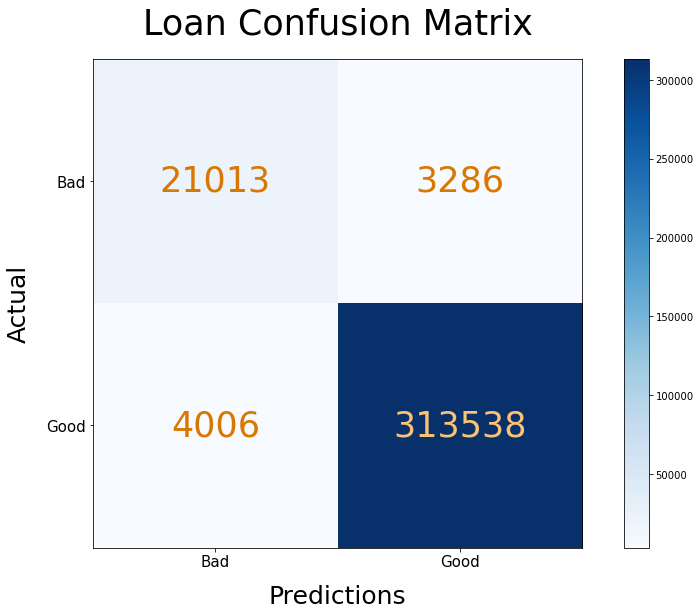

In [39]:
# Plot confusion matrix
plot_cm(Solid['loan_status'],Solid['model_preds'])


In [40]:
cl_metrics(Solid['loan_status'],Solid['model_preds'])

Total Loans:  341843
Total Predicted GoodL  316824
Total Predicted Bad:  25019
Accuracy Score:  0.979
Recall Score:  0.987
Specificity Score:  0.865
Precision Score:  0.99
F1 Score:  0.989


### Adjust model to decrease Type 1 errors
Pursuant to Histogram of Results['pred_probability'] that shows a vast majority of loans scoring >=.95 and a desire to prioritize avoiding the approval of loans that go bad, changing the binary 'model_preds' column from a pred_probability score threshold of .5 as the determining score to a score of .95 will improve Precision Score.

In [41]:
# Type 1 error minimizing Dataframe
bad_bias = pd.DataFrame.copy(Results)

In [42]:
bad_bias['model_preds'] = [1 if x>=.95 else 0 for x in bad_bias['pred_probability']]

In [43]:
# Percentage of loans predicted "good" under bad_bias
round(bad_bias['model_preds'].sum()/len(bad_bias),3)

0.733

In [62]:
# Confusion matrix
conf_mat(bad_bias['loan_status'],bad_bias['model_preds'])

,pred bad,pred good
actual bad,51950,3286
actual good,63686,313538


<ipython-input-15-a6354ee2db01>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, size=15)
<ipython-input-15-a6354ee2db01>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels, size=15)


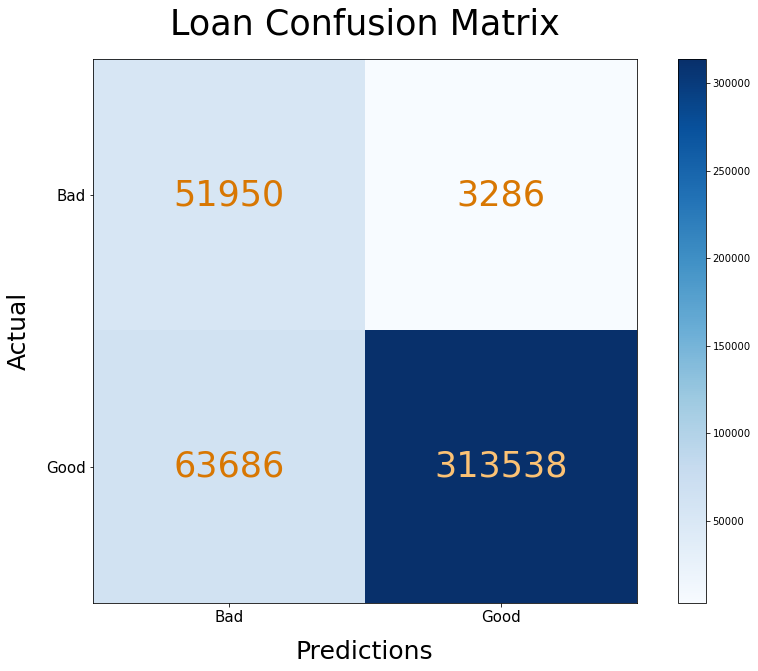

In [63]:
# Plot confusion matrix
plot_cm(bad_bias['loan_status'],bad_bias['model_preds'])

In [64]:
cl_metrics(bad_bias['loan_status'],bad_bias['model_preds'])

Total Loans:  432460
Total Predicted GoodL  316824
Total Predicted Bad:  115636
Accuracy Score:  0.845
Recall Score:  0.831
Specificity Score:  0.941
Precision Score:  0.99
F1 Score:  0.904


In [70]:
Results['model_preds'] = bad_bias['model_preds'].copy()

# Feature Importance

In [82]:
feat_imp

{'loan_amnt': 0.020787448181880035,
 'term': 0.009396865994726715,
 'sub_grade': 0.0022796835679590173,
 'annual_inc': 0.0006543635732572323,
 'loan_status': 0.0022789426415631914,
 'pymnt_plan': 0.0022875444027489404,
 'delinq_2yrs': 0.0001724377369941655,
 'fico_range_low': 0.00011042082936670288,
 'revol_bal': 0.00026108178729343994,
 'revol_util': 0.0007520838556574735,
 'total_acc': 0.00026423114898126794,
 'initial_list_status': 0.6312573759000002,
 'last_fico_range_high': 0.32596802556518906,
 'tot_coll_amt': 0.00010785859063265815,
 'tot_cur_bal': 0.0001541524193968929,
 'total_rev_hi_lim': 5.664124795452323e-06,
 'avg_cur_bal': 0.00019443326789946936,
 'delinq_amnt': 0.000744822040120269,
 'mo_sin_rcnt_rev_tl_op': 3.697227555553725e-06,
 'num_accts_ever_120_pd': 1.1127954822555674e-05,
 'num_op_rev_tl': 0.0009118718297459068,
 'num_rev_accts': 0.00010962376842096078,
 'num_tl_op_past_12m': 0.0009844190201190994,
 'percent_bc_gt_75': 0.00015634572318995162,
 'joint_app': 3.1988

# References:
1. Lenders Club 2007-2018 (by Nathan George) - https://www.kaggle.com/wordsforthewise/lending-club?select=accepted_2007_to_2018Q4.csv.gz
2. Data Dictionary - https://www.kaggle.com/wordsforthewise/lending-club/discussion/170691
3. Cleaning Tips - https://www.dataquest.io/blog/machine-learning-preparing-data/
4. What is a 'trade' - https://www.thepennyhoarder.com/investing/lending-club-note-trading/
5. Subgrade order - https://www.lendingclub.com/foliofn/rateDetail.action
6. Datetime Conversion 1 - https://stackoverflow.com/questions/2265357/parse-date-string-and-change-format
7. Datetime Conversion 2 - https://stackoverflow.com/questions/9504356/convert-string-into-date-type-on-python
8. initial_list_status column definitions - https://www.lendacademy.com/lending-club-whole-loan-program-one-year-later/
9. GradientBoostingClassifier - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
10. Plotting ROC curve - https://www.youtube.com/watch?v=uVJXPPrWRJ0
11. sns.distplot - https://git.generalassemb.ly/DSIR-412/lesson-classification-metrics-ii
12. Confusion Matrix - https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
13. Confusion Matrix - https://stackoverflow.com/questions/3529666/matplotlib-matshow-labels
14. Confusion Matrix - https://stackoverflow.com/questions/17022154/changing-matshow-xticklabel-position-from-top-to-bottom-of-the-figure
15. Dataframe Copy - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.copy.html
16. List Copy - https://www.w3schools.com/python/python_ref_list.asp
17. Confusion Matrix - https://stackoverflow.com/questions/21712047/matplotlib-imshow-matshow-display-values-on-plot
18. Confusion Matrix - https://stackoverflow.com/questions/42840044/color-a-specific-bar-in-histogram-using-python